In [1]:
import sympy
sympy.init_printing()

(u_max, u_star, rho_max,
 rho_star, A, B) = sympy.symbols('u_max u_star rho_max rho_star A B')

In [2]:
eq1 = sympy.Eq(0, u_max * rho_max * (1 - A * rho_max - B * rho_max**2))
eq2 = sympy.Eq(0, u_max * (1 - 2 * A * rho_star - 3 * B * rho_star**2))
eq3 = sympy.Eq(u_star, u_max * (1 - A * rho_star - B * rho_star**2))

In [3]:
eq1

In [4]:
eq2

In [5]:
eq3

In [6]:
eq2 - 3 * eq3

In [7]:
eq4 = sympy.Eq(eq2.lhs - 3 * eq3.lhs, eq2.rhs - 3 * eq3.rhs)
eq4

In [8]:
eq4.simplify()

In [9]:
eq4

In [10]:
eq4.expand()

In [11]:
rho_sol = sympy.solve(eq4, rho_star)[0]
rho_sol

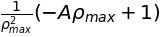

In [12]:
B_sol = sympy.solve(eq1, B)[0]
B_sol

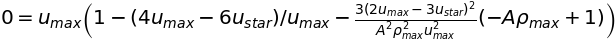

In [13]:
quadA = eq2.subs([(rho_star, rho_sol), (B, B_sol)])
quadA

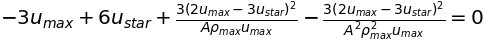

In [14]:
quadA.simplify()

In [15]:
A_sol = sympy.solve(quadA, A)

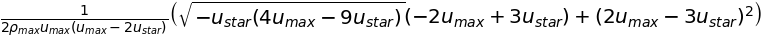

In [16]:
A_sol[0]

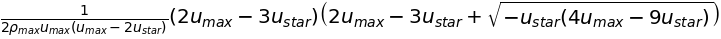

In [17]:
A_sol[1]

In [18]:
A_val_0 = A_sol[0].evalf(subs={u_star:0.7, u_max:1.0, rho_max:10.0})
A_val_0

In [19]:
A_val_1 = A_sol[1].evalf(subs={u_star:0.7, u_max:1.0, rho_max:10.0})
A_val_1

In [20]:
A_val = max(A_val_0, A_val_1)
A_val

In [21]:
B_val = B_sol.evalf(subs={rho_max:10.0, A: A_val})
B_val

In [22]:
sympy.init_printing(use_latex=False)

In [23]:
rho_max = 10.0
u_max = 1.0

In [24]:
def flux(rho, u_max, A, B):
    """
    Computes the traffic flux for the better model.
    
    Parameters
    ----------
    rho : numpy.ndarray
       Traffic density along the road as a 1D array of floats.
    u_max : float
        Maximum speed allowed on the road.
    A : float
        Scaling coefficient for rho.
    B : float
        Scaling coefficient for rho squared.
    
    Returns
    -------
    F : numpy.ndarray
        The traffic flux along the road as a 1D array of floats.
    """
    F = rho * u_max * (1.0 - A * rho - B * rho**2)
    return F

In [25]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [26]:
# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [27]:
def rho_green_light(x, rho_light):
    """
    Computes the "green light" initial condition.
    It consists of a shock with a linear distribution behind it.
    
    Parameters
    ----------
    x : numpy.ndarray
        Locations on the road as a 1D array of floats.
    rho_light : float
        Car density at the stoplight.
    
    Returns
    -------
    rho : numpy.ndarray
        The initial car density along the road
        as a 1D array of floats.
    """
    rho = numpy.zeros_like(x)
    mask = numpy.where(x < 2.0)
    rho[mask] = rho_light * x[mask] / 2.0
    return rho

In [28]:
# Set parameters.
nx = 81  # number of locations on the road
L = 4.0  # length of the road
dx = L / (nx - 1)  # distance between two consecutive locations
nt = 30  # number of time steps to compute
rho_light = 5.0  # car density at the traffic light.

# Define the locations on the road.
x = numpy.linspace(0.0, L, num=nx)

# Compute the initial traffic density.
rho0 = rho_green_light(x, rho_light)

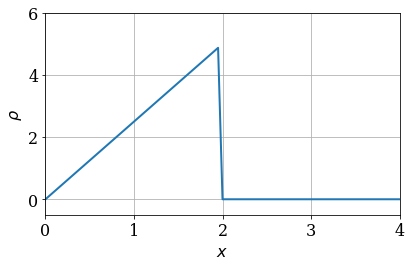

In [29]:
# Plot the initial car density on the road.
fig = pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$\rho$')
pyplot.grid()
line = pyplot.plot(x, rho0,
                   color='C0', linestyle='-', linewidth=2)[0]
pyplot.xlim(0.0, L)
pyplot.ylim(-0.5, 6.0)
pyplot.tight_layout();

In [30]:
def ftbs(rho0, nt, dt, dx, bc_value, *args):
    """
    Computes the traffic density on the road 
    at a certain time given the initial traffic density.
    
    Parameters
    ----------
    rho0 : numpy.ndarray
        The initial car density along the road
        as a 1D array of floats.
    nt : integer
        The number of time steps to compute.
    dt : float
        The time-step size to integrate.
    dx : float
        The distance between two consecutive locations.
    bc_value : float
        The constant density at the first station.
    args : list or tuple
        Positional arguments to be passed to the flux function.
    
    Returns
    -------
    rho_hist : list of numpy.ndarray objects
        The history of the car density along the road.
    """
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    for n in range(nt):
        # Compute the flux.
        F = flux(rho, *args)
        # Advance in time.
        rho[1:] = rho[1:] - dt / dx * (F[1:] - F[:-1])
        # Set the left boundary condition.
        rho[0] = bc_value
        # Record the time-step solution.
        rho_hist.append(rho.copy())
    return rho_hist

In [31]:
# Set time-step size based on CFL limit.
sigma = 1.0
dt = sigma * dx / u_max  # time-step size

# Compute the traffic density at all time steps.
rho_hist = ftbs(rho0, nt, dt, dx, rho0[0], u_max, A_val, B_val)

In [32]:
from matplotlib import animation
from IPython.display import HTML

In [33]:
def update_plot(n, rho_hist):
    """
    Update the line y-data of the Matplotlib figure.
    
    Parameters
    ----------
    n : integer
        The time-step index.
    rho_hist : list of numpy.ndarray objects
        The history of the numerical solution.
    """
    fig.suptitle('Time step {:0>2}'.format(n))
    line.set_ydata(rho_hist[n])

In [34]:
# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)
# Display the video.
HTML(anim.to_html5_video())

# Godunov's method

In [35]:
import numpy
from matplotlib import pyplot, animation
from IPython.display import HTML
%matplotlib inline

In [36]:
# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [38]:
from traffic import rho_red_light, flux

In [39]:
help(rho_red_light)

Help on function rho_red_light in module traffic:

rho_red_light(x, rho_max)
    Computes the "red light" initial condition with shock.
    
    Parameters
    ----------
    x : numpy.ndarray
        Locations on the road as a 1D array of floats.
    rho_max : float
        The maximum traffic density allowed.
    
    Returns
    -------
    rho : numpy.ndarray
        The initial car density along the road as a 1D array of floats.



In [40]:
# Set parameters.
nx = 100  # number of cells along the road
L = 4.0  # length of the road
dx = L / nx  # cell width
nt = 30  # number of time steps to compute
rho_max = 10.0  # maximum traffic density allowed
u_max = 1.0  # speed limit

# Get the grid-cell centers.
# x_i is now the center of the i-th cell.
x = numpy.linspace(0.0 + 0.5 * dx, L - 0.5 * dx, num=nx)

# Compute the initial traffic density.
rho0 = rho_red_light(x, rho_max)

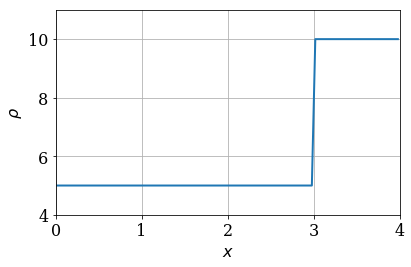

In [41]:
# Plot the initial car density on the road.
fig = pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$\rho$')
pyplot.grid()
line = pyplot.plot(x, rho0,
                   color='C0', linestyle='-', linewidth=2)[0]
pyplot.xlim(0.0, L)
pyplot.ylim(4.0, 11.0)
pyplot.tight_layout();

In [42]:
def godunov(rho0, nt, dt, dx, bc_values, *args):
    """
    Computes and returns the history of the traffic density
    on the road using a Godunov scheme
    with a Lax-Friedrichs flux.
    
    Parameters
    ----------
    rho0 : numpy.ndarray
        The initial traffic density along the road
        as a 1D array of floats.
    nt : integer
        The number of time steps to compute.
    dt : float
        The time-step size to integrate.
    dx : float
        The distance between two consecutive locations.
    bc_values : tuple or list
        The value of the density at the first and last locations
        as a tuple or list of two floats.
    args : list
        Positional arguments to be passed to the flux function.
    
    Returns
    -------
    rho_hist : list of numpy.ndarray objects
        The history of the car density along the road
        as a list of 1D arrays of floats.
    """
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    for n in range(nt):
        rhoL = rho[:-1]  # i-th value at index i-1/2
        rhoR = rho[1:]  # i+1-th value at index i-1/2
        # Compute the flux at cell boundaries.
        F = 0.5 * (flux(rhoL, *args) + flux(rhoR, *args) -
                   dx / dt * (rhoR - rhoL))
        # Advance in time.
        rho[1:-1] = rho[1:-1] - dt / dx * (F[1:] - F[:-1])
        # Apply boundary conditions.
        rho[0], rho[-1] = bc_values
        # Record the time-step solution.
        rho_hist.append(rho.copy())
    return rho_hist

In [43]:
# Set time-step size based on CFL limit.
sigma = 1.0
dt = sigma * dx / u_max  # time-step size

# Compute the traffic density at all time steps.
rho_hist = godunov(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                   u_max, rho_max)

In [44]:
def update_plot(n, rho_hist):
    """
    Update the line y-data of the Matplotlib figure.
    
    Parameters
    ----------
    n : integer
        The time-step index.
    rho_hist : list of numpy.ndarray objects
        The history of the numerical solution.
    """
    fig.suptitle('Time step {:0>2}'.format(n))
    line.set_ydata(rho_hist[n])

In [45]:
# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)
# Display the video.
HTML(anim.to_html5_video())

30